# Week 4 Lecture 1 - Backdoor paths

McElreath's lectures for the whole book are available here: https://github.com/rmcelreath/stat_rethinking_2022

An R/Stan repo of code is available here: https://vincentarelbundock.github.io/rethinking2/

An excellent port to Python/PyMC Code is available here: https://github.com/dustinstansbury/statistical-rethinking-2023

You are encouraged to work through both of these versions to re-enforce what we're doing in class.

In [22]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import scipy as sp 
import random as rd
import pymc as pm
from matplotlib import pyplot as plt
import arviz as az

# Helper functions
def stdize(x):
    return (x-np.mean(x))/np.std(x)


def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

## Return to Waffle Houses

From the waffle house data we can assert a full causal graph:

![](wafflez.jpg)

And by importing the data, we can check the implications of our assumptions, and how playing with the elemental confounds changes the effect sizes we see in our statistical model.

In [9]:
# Import data
ddata = pd.read_csv('../Data/WaffleDivorce3.csv',sep=";")
# Display top 5 rows
ddata.head()

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00
3,Arkansas,AR,2.92,24.3,26.4,1.70,13.5,1.22,41,1,111115,435450,0.26
4,California,CA,37.25,26.8,19.1,0.39,8.0,0.24,0,0,0,379994,0.00


In [10]:
# Standardize variables
AgeMarriage = stdize(ddata.MedianAgeMarriage.values)
MarriageRate = stdize(ddata.Marriage.values)
PropSlaves1860 = stdize(ddata.PropSlaves1860.values)
Divorce = stdize(ddata.Divorce.values)
WaffleHouses = stdize(ddata.WaffleHouses.values)
South = stdize(ddata.South.values)

With this diagram and data, let's see how blocking the backdor through conditioning on S versus A and M changes the effect of W on D.

In [11]:
with pm.Model() as Smod:
    # Baseline intercept
    β0 = pm.Normal('Intercept', 0, 0.2)
    # Waffle House effect
    βWH = pm.Normal('WaffleHouses', 0, 0.5)
    # Southern
    βS = pm.Normal('South', 0, 0.5)
    # Linear model
    μ = β0+βWH*WaffleHouses+βS*South
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=Divorce)

In [12]:
with pm.Model() as AMmod:
    # Baseline intercept
    β0 = pm.Normal('Intercept', 0, 0.2)
    # Waffle House effect
    βWH = pm.Normal('WaffleHouses', 0, 0.5)
    # Marriage age
    βA = pm.Normal('AgeMarriage', 0, 0.5)
    # Marriage rate
    βM = pm.Normal('MarriageRate', 0, 0.5)
    # Linear model
    μ = β0+βWH*WaffleHouses+βA*AgeMarriage+βM*MarriageRate
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=Divorce)

In [13]:
with pm.Model() as Amod:
    # Baseline intercept
    β0 = pm.Normal('Intercept', 0, 0.2)
    # Waffle House effect
    βWH = pm.Normal('WaffleHouses', 0, 0.5)
    # Marriage age
    βA = pm.Normal('AgeMarriage', 0, 0.5)
    # Linear model
    μ = β0+βWH*WaffleHouses+βA*AgeMarriage
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=Divorce)

In [14]:
with pm.Model() as Mmod:
    # Baseline intercept
    β0 = pm.Normal('Intercept', 0, 0.2)
    # Waffle House effect
    βWH = pm.Normal('WaffleHouses', 0, 0.5)
    # Marriage reat
    βM = pm.Normal('MarriageRate', 0, 0.5)
    # Linear model
    μ = β0+βWH*WaffleHouses+βM*MarriageRate
    # Error
    σ = pm.Uniform('SD_obs', 0, 10)
    # Likelihood
    Yi = pm.Normal('Yi', μ, σ, observed=Divorce)

In [15]:
with Smod:
    trace_s = pm.sample(1000)
with AMmod:
    trace_am = pm.sample(1000)
with Amod:
    trace_a = pm.sample(1000)
with Mmod:
    trace_m = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, WaffleHouses, South, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, WaffleHouses, AgeMarriage, MarriageRate, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, WaffleHouses, AgeMarriage, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, WaffleHouses, MarriageRate, SD_obs]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


In [16]:
# Look at southern model results
pm.summary(trace_s)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,0.004,0.112,-0.205,0.218,0.002,0.002,4126.0,3319.0,1.0
SD_obs,0.989,0.102,0.808,1.188,0.002,0.001,3192.0,2616.0,1.0
South,0.286,0.174,-0.058,0.596,0.003,0.002,2626.0,2961.0,1.0
WaffleHouses,0.053,0.175,-0.276,0.388,0.003,0.003,2499.0,2470.0,1.0


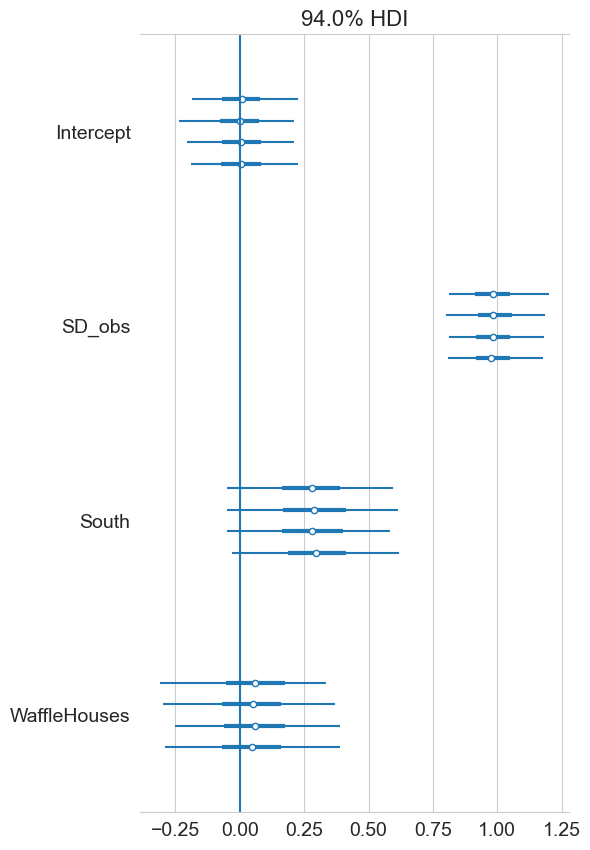

In [17]:
pm.plot_forest(trace_s)
plt.axvline(0)
plt.tight_layout()
plt.savefig('waffleS.jpg',dpi=300)

In [18]:
pm.summary(trace_am)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
AgeMarriage,-0.576,0.161,-0.899,-0.292,0.003,0.002,3503.0,2802.0,1.0
Intercept,-0.001,0.099,-0.195,0.179,0.001,0.001,4750.0,3245.0,1.0
MarriageRate,-0.045,0.163,-0.361,0.256,0.003,0.003,3487.0,2726.0,1.0
SD_obs,0.830,0.090,0.661,0.990,0.002,0.001,3408.0,2521.0,1.0
WaffleHouses,0.179,0.117,-0.044,0.394,0.002,0.001,3929.0,2639.0,1.0


In [19]:
pm.summary(trace_a)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
AgeMarriage,-0.547,0.114,-0.769,-0.341,0.002,0.001,5205.0,3133.0,1.0
Intercept,0.001,0.100,-0.191,0.191,0.001,0.002,5617.0,3271.0,1.0
SD_obs,0.825,0.086,0.664,0.979,0.001,0.001,4875.0,3192.0,1.0
WaffleHouses,0.178,0.116,-0.054,0.389,0.002,0.001,5517.0,2746.0,1.0


In [20]:
pm.summary(trace_m)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.000,0.112,-0.216,0.203,0.001,0.002,5687.0,3016.0,1.0
MarriageRate,0.343,0.133,0.088,0.596,0.002,0.001,5969.0,3175.0,1.0
SD_obs,0.944,0.100,0.762,1.129,0.001,0.001,5142.0,3275.0,1.0
WaffleHouses,0.230,0.131,-0.013,0.475,0.002,0.001,6016.0,2947.0,1.0


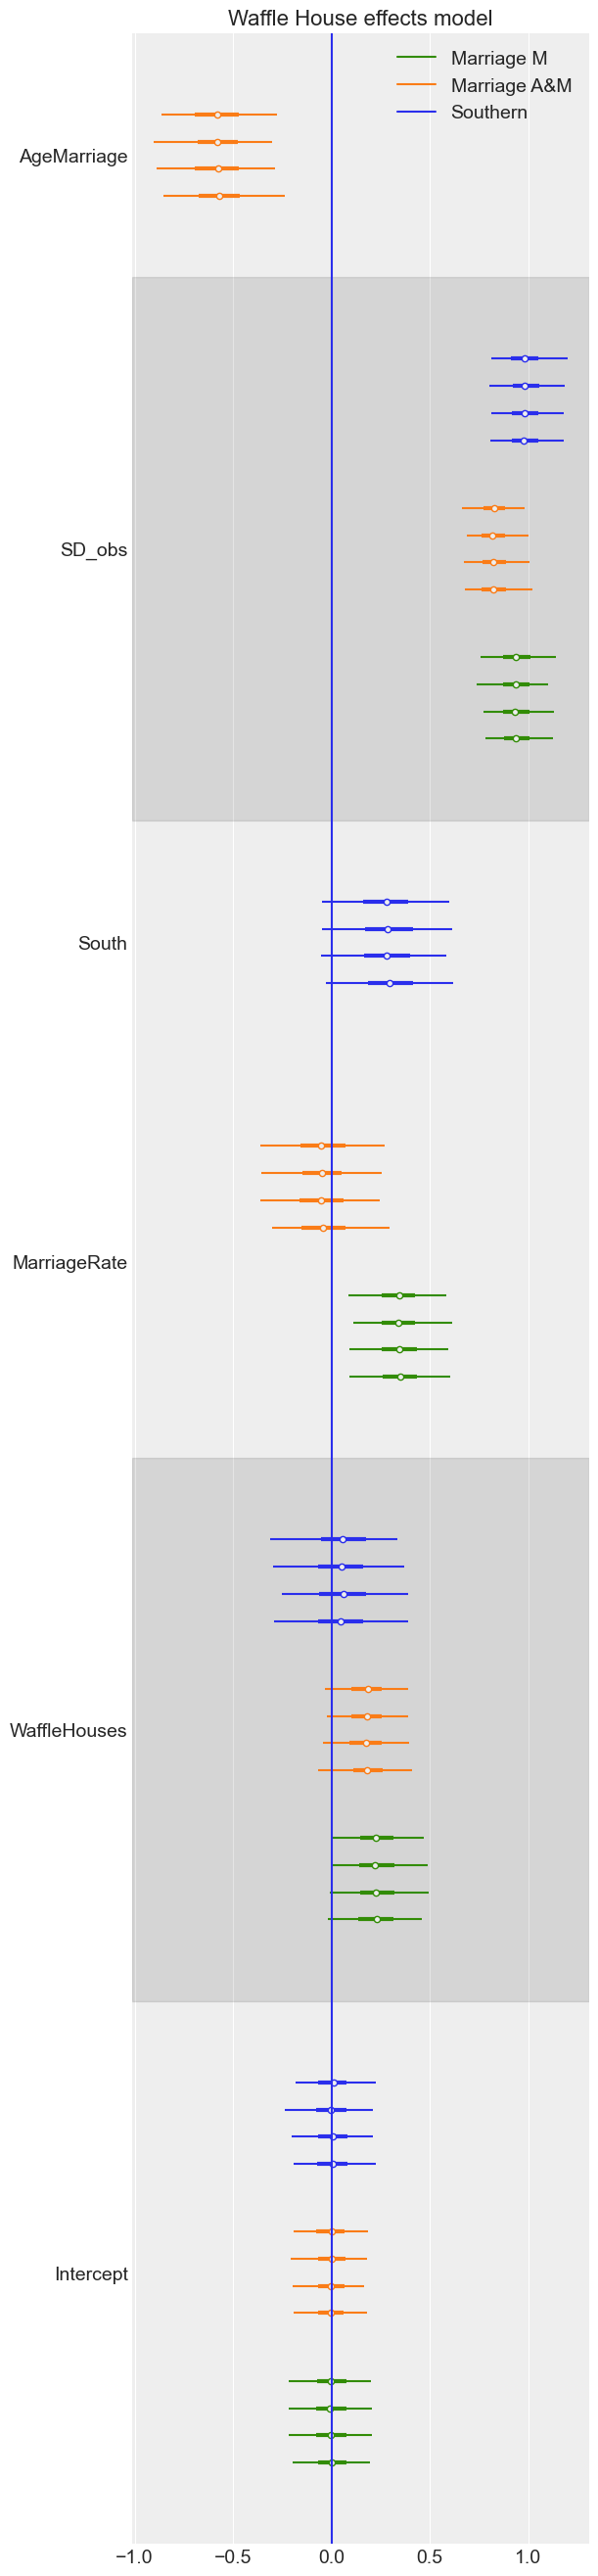

In [23]:
az.style.use("arviz-darkgrid")

axes = az.plot_forest(
    [trace_s, trace_am, trace_m], model_names=["Southern", "Marriage A&M","Marriage M"])
axes[0].set_title("Waffle House effects model")
plt.axvline(0)
plt.show()

Humm, we can see that South negates the Waffle House effect as expected, however conditioning on M and A doesn't do the same thing...there must be other, unmeasured backdoor paths through W to have an effect. 